<a href="https://colab.research.google.com/github/VenugopalBhamidi/Prerequisite-test-ES335/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
device

device(type='cuda')

torch.Size([3, 1280, 852])


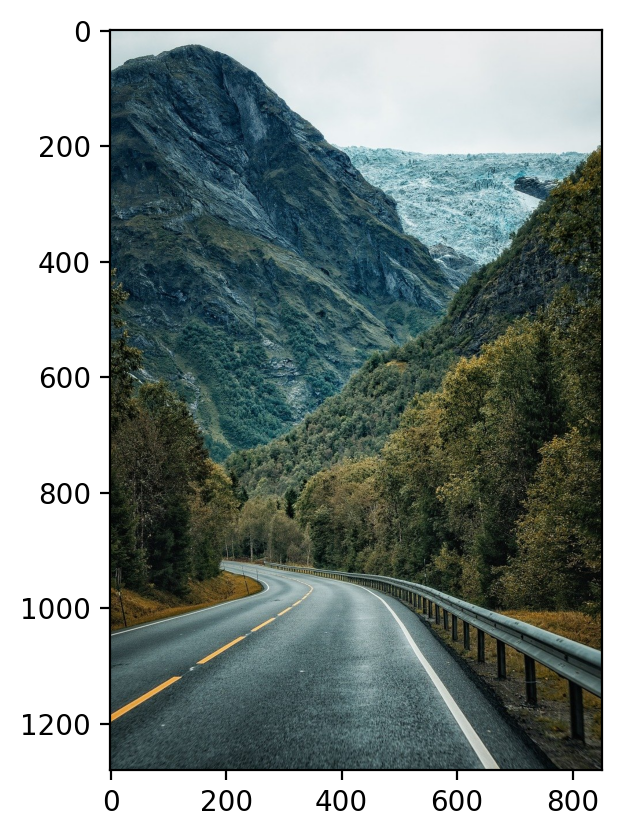

In [3]:
if os.path.exists("/content/road-8284023_1280.jpg"):
  img = torchvision.io.read_image("/content/road-8284023_1280.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'b h w -> h w b').numpy())

In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)) #converts to 1D array of 3*h*w 3 is channels
img_scaled = img_scaled.reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

cropped_image = torchvision.transforms.functional.crop(img_scaled.cpu(), 200, 400, 400, 400)
cropped_image.to(device)
cropped_image.shape

torch.Size([3, 400, 400])

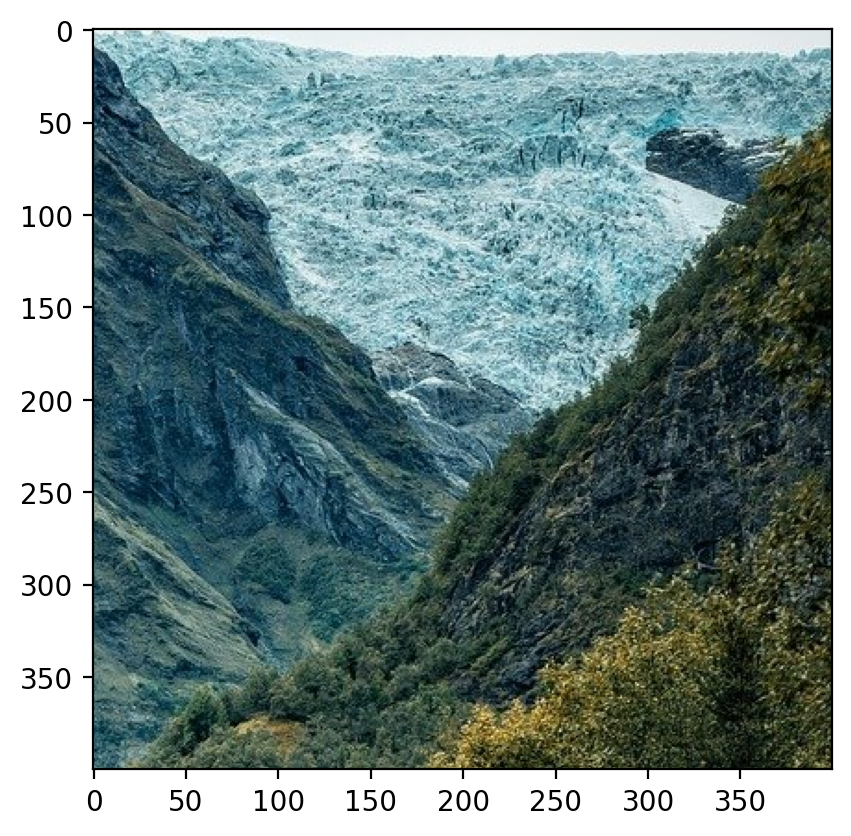

In [5]:
plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())

In [6]:
cropped_image.shape

torch.Size([3, 400, 400])

In [7]:
import cv2
import torch
img = cropped_image.permute(1, 2, 0).numpy()  # Change (C, H, W) to (H, W, C) for OpenCV

print('Original Dimensions : ', img.shape)

# Resize the image
scale_percent = 50  # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# Resize the image
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
print('Resized Dimensions : ', resized.shape)

Original Dimensions :  (400, 400, 3)
Resized Dimensions :  (200, 200, 3)


In [8]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).to(torch.float32)

    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

In [9]:
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
# Note: OpenCV uses (H, W, C) format, so we need to permute to (C, H, W) for PyTorch
resized = torch.from_numpy(resized).permute(2, 0, 1)  # Change from (H, W, C) to (C, H, W)
resized = resized.to(device)
print(resized.shape)  # Check the shape of the tensor

torch.Size([3, 200, 200])


In [10]:
road_X, road_Y = create_coordinate_map(resized)
road_X_400, road_Y_400 = create_coordinate_map(cropped_image)
road_X.shape, road_Y.shape
road_Y = torch.tensor(road_Y).to(device)
road_Y_400 = torch.tensor(road_Y_400).to(device)

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X.cpu())  #road_X will work for GPU, but sklearn is for cpu
scaler_X_400 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X_400.cpu())
road_X_scaled = scaler_X.transform(road_X.cpu())
road_X_scaled = torch.tensor(road_X_scaled).to(device)
road_X_400_scaled = scaler_X_400.transform(road_X_400.cpu())
road_X_400_scaled = torch.tensor(road_X_400_scaled).to(device)

# Set to dtype float32
road_X_scaled = road_X_scaled.to(torch.float32)
road_X_400_scaled = road_X_400_scaled.to(torch.float32)

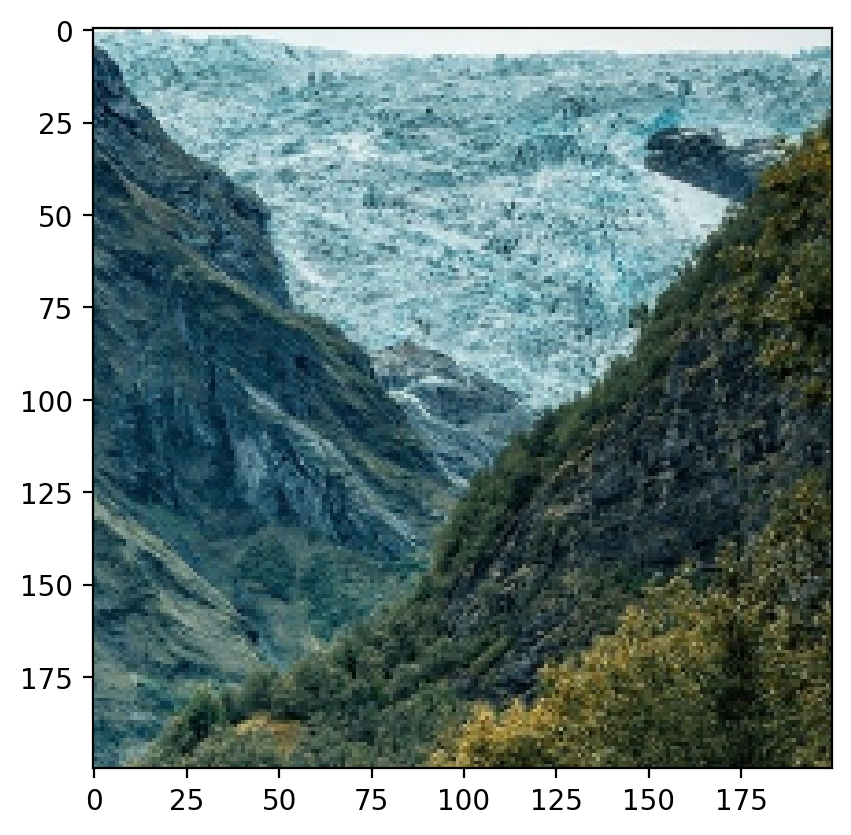

In [11]:
plt.imshow(rearrange(resized, 'c h w -> h w c').cpu().numpy())

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [13]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [14]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ##Now plotting for original image

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [15]:
def create_rff_features(X, num_features, sigma, device, batch_size=5000):
    n_samples, n_features = X.shape

    # Generate random weights and bias for RFF (weights can be large, so precompute and store on GPU)
    W = torch.randn(n_features, num_features, device=device) / sigma  # Random Gaussian weights
    b = 2 * torch.pi * torch.rand(num_features, device=device)  # Random bias

    Z_list = []  # Store the chunks of transformed data

    # Process the input in smaller batches to reduce memory usage
    for i in range(0, n_samples, batch_size):
        X_batch = X[i:i + batch_size]  # Slice the batch from the input tensor
        Z_batch = torch.matmul(X_batch, W) + b  # Linear transformation
        Z_batch = torch.cos(Z_batch) * (2.0 / torch.sqrt(torch.tensor(num_features, dtype=torch.float32, device=device)))  # Apply cosine and normalize
        Z_list.append(Z_batch)

    # Concatenate all the processed batches to form the final tensor
    Z = torch.cat(Z_list, dim=0)

    return Z

In [16]:
def create_rff_features_old(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [17]:
X_rff_400 = create_rff_features_old(road_X_400_scaled,9000, 0.005)

In [18]:
X_rff = create_rff_features_old(road_X_scaled, 9000, 0.005)

In [19]:
net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only
net.to(device)

train(net, 0.005, X_rff, road_Y, 2000)

Epoch 0 loss: 0.209916
Epoch 100 loss: 0.051598
Epoch 200 loss: 0.045812
Epoch 300 loss: 0.044063
Epoch 400 loss: 0.042903
Epoch 500 loss: 0.042072
Epoch 600 loss: 0.041450
Epoch 700 loss: 0.040970
Epoch 800 loss: 0.040592
Epoch 900 loss: 0.040291
Epoch 1000 loss: 0.040049
Epoch 1100 loss: 0.039855
Epoch 1200 loss: 0.039699
Epoch 1300 loss: 0.039573
Epoch 1400 loss: 0.039473
Epoch 1500 loss: 0.039392
Epoch 1600 loss: 0.039328
Epoch 1700 loss: 0.039276
Epoch 1800 loss: 0.039233
Epoch 1900 loss: 0.039198


0.039169032126665115

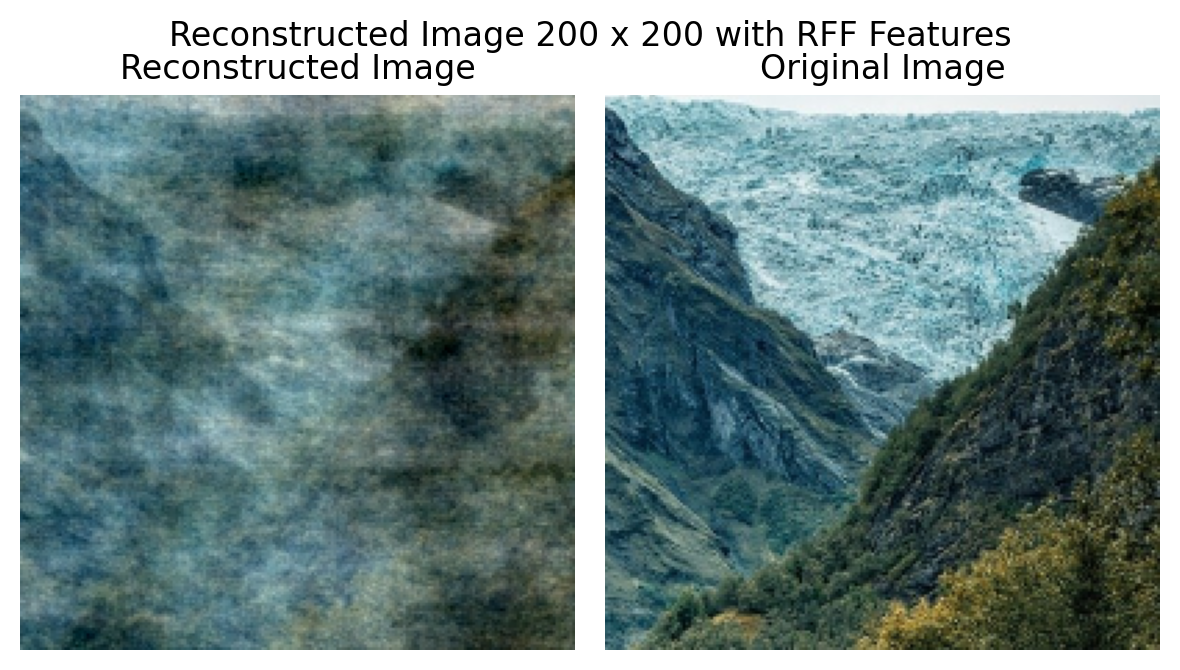

In [20]:
plot_reconstructed_and_original_image(resized, net, X_rff, title="Reconstructed Image 200 x 200 with RFF Features")

In [21]:
print(cropped_image.shape)
print(X_rff_400.shape)
print(resized.shape)
print(X_rff.shape)

torch.Size([3, 400, 400])
torch.Size([160000, 9000])
torch.Size([3, 200, 200])
torch.Size([40000, 9000])


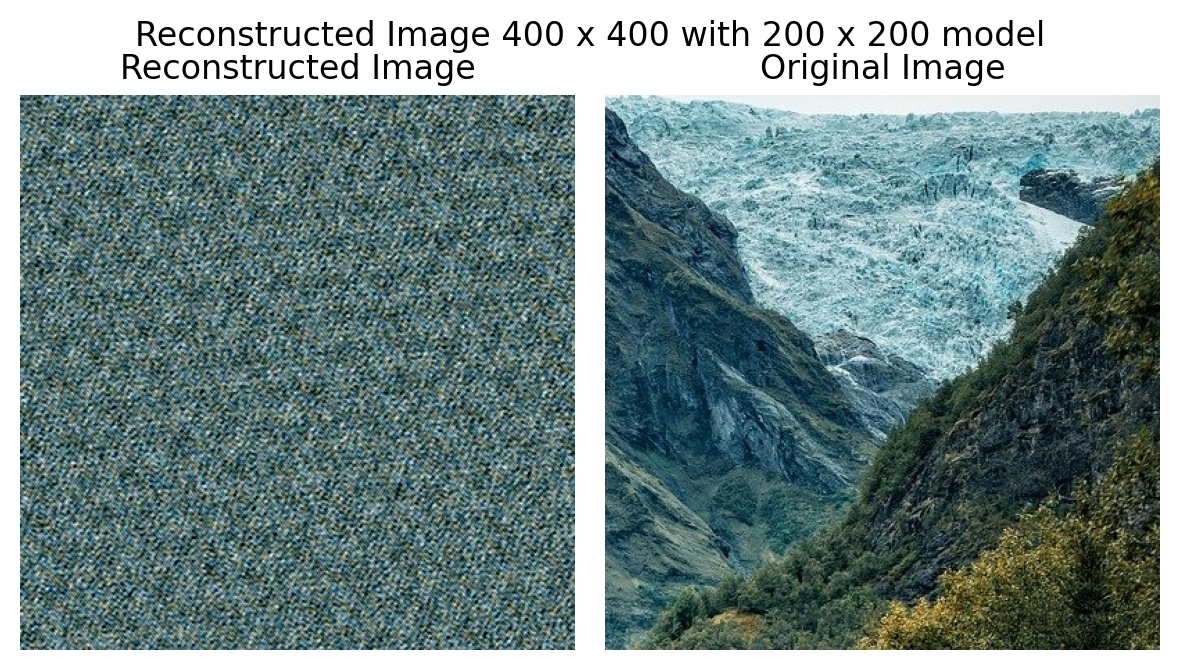

In [22]:
plot_reconstructed_and_original_image(cropped_image, net, X_rff_400, title="Reconstructed Image 400 x 400 with 200 x 200 model")